### Exercise project_4 Random forest ML model. I will use a new dataset "Student Alcohol Consumption" (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption?resource=download). There are two datasets, i will combine them into one (Portuguese language course, Math course).

In [1321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Cleaning and optimizing the dataset:

In [1322]:
# load data 
df_por = pd.read_csv("student-por.csv")
df_mat = pd.read_csv("student-mat.csv")


In [1323]:
# Example: combining two datasets with the same structure
df = pd.concat([df_mat, df_por], ignore_index=True)

In [1324]:
df.describe()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [1325]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [1326]:
# check for dublicates:
df.duplicated().sum()

0

In [1327]:
# check for missing values 
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

#### I will create target variable "High_alcohol_use" based on Dalc and Walc variables (workday/weekend alcohol consumption 1-5). This dataset uses the following scale: 1 – very low, 2 – low, 3 – average, 4 – high, 5 – very high. If a student's average score is above 3, it indicates high alcohol consumption. 

In [1328]:
df["Dalc"].value_counts()


Dalc
1    727
2    196
3     69
5     26
4     26
Name: count, dtype: int64

In [1329]:
df["Walc"].value_counts()

Walc
1    398
2    235
3    200
4    138
5     73
Name: count, dtype: int64

In [1330]:
# creating a new variable based on  Dalc and Walc variables:
df['high_alcohol_use'] = ((df['Walc'] + df['Dalc']) / 2 > 3).map({True: 1, False: 0})

In [1331]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,high_alcohol_use
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,0


In [1332]:
# check the distribution of the target variable
# not balanced variable, the same problem as in the previous dataset. To avoid overfitting, I will implement downsampling, 
# meaning will remove some of the catergory 0.
df["high_alcohol_use"].value_counts()


high_alcohol_use
0    935
1    109
Name: count, dtype: int64

In [1333]:
from sklearn.utils import resample

# downsampling. As dataset should contain 500 rows or more, I will downsample the majority class to 400 rows. -> the model didn't work weel
# downsampling_2. This time I will downsample the majority class to 250 rows.

# Step 1: Separate classes
majority = df[df['high_alcohol_use'] == 0]  
minority = df[df['high_alcohol_use'] == 1] 

# Step 2: Downsample majority to 400
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=250, # first time I tried 400, but the model didn't work well 
    random_state=42
)

# Step 3: Combine downsampled majority with full minority
df = pd.concat([majority_downsampled, minority])

In [1334]:
df["high_alcohol_use"].value_counts()

high_alcohol_use
0    250
1    109
Name: count, dtype: int64

In [1335]:
df.reset_index(drop=True, inplace=True)

In [1336]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,high_alcohol_use
0,MS,F,18,U,GT3,T,3,3,services,services,...,3,4,1,1,5,0,10,9,9,0
1,GP,M,15,U,GT3,T,4,0,teacher,other,...,4,3,1,1,1,8,11,11,10,0
2,GP,M,17,U,GT3,T,4,4,teacher,teacher,...,5,5,1,3,2,14,11,9,9,0
3,GP,F,16,U,GT3,T,4,3,health,other,...,3,5,1,5,2,2,14,14,15,0
4,GP,M,18,U,LE3,T,3,4,services,other,...,3,3,1,3,5,6,16,16,17,0


In [1337]:
# checking support variables:
df["sex"].value_counts()

sex
M    191
F    168
Name: count, dtype: int64

In [1338]:
# R - means rural, U - means urban, we can use rural addresses as it may effect the alcohol use
df["address"].value_counts()

address
U    256
R    103
Name: count, dtype: int64

In [1339]:
#'LE3' - less or equal to 3 or 'GT3' - greater than 3
df["famsize"].value_counts()

famsize
GT3    240
LE3    119
Name: count, dtype: int64

In [1340]:
# 'T' - living together or 'A' - apart
df["Pstatus"].value_counts()

Pstatus
T    314
A     45
Name: count, dtype: int64

In [1341]:
df["guardian"].value_counts()

guardian
mother    248
father     84
other      27
Name: count, dtype: int64

In [1342]:
# use of OneHotEncoder for "guardian" column , it will create multiple columns with numeric values:
from sklearn.preprocessing import OneHotEncoder
variables = ["guardian"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [1343]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,high_alcohol_use,guardian_father,guardian_mother,guardian_other
0,MS,F,18,U,GT3,T,3,3,services,services,...,1,5,0,10,9,9,0,1,0,0
1,GP,M,15,U,GT3,T,4,0,teacher,other,...,1,1,8,11,11,10,0,0,1,0
2,GP,M,17,U,GT3,T,4,4,teacher,teacher,...,3,2,14,11,9,9,0,0,1,0
3,GP,F,16,U,GT3,T,4,3,health,other,...,5,2,2,14,14,15,0,0,1,0
4,GP,M,18,U,LE3,T,3,4,services,other,...,3,5,6,16,16,17,0,0,1,0


In [1344]:
# next we will remove one new boolean variable "guardian_other" (since it's going to be represented
# by a straight line of zeroes)
df = df.drop("guardian_other", axis=1)

In [1345]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'high_alcohol_use',
       'guardian_father', 'guardian_mother'],
      dtype='object')

In [1346]:
#  extra educational support, the same binary yes/not for "famsup"- family educational support ,
# "paid" - extra paid classes within the course subject, "activities" - extra-curricular activities,
# "nursery"- attended nursery school,'higher', 'internet', 'romantic'
df["schoolsup"].value_counts()

schoolsup
no     331
yes     28
Name: count, dtype: int64

In [1347]:
# now we will use LabelEncoder to converts the value of column to 0 or 1 for such columns that have just 2 unique values

from sklearn.preprocessing import LabelEncoder
# list of all boolean variables we want to convert
variables = ['sex', "address","famsize","Pstatus","schoolsup","famsup","paid","activities",
             "nursery","higher","internet","romantic"]

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [1348]:
# "famrel" - quality of family relationships (numeric: from 1 - very bad to 5 - excellent),
# the same values for "freetime" - free time after school, "goout" - going out with friends,
# "health" - current health status.
df["famrel"].value_counts()

famrel
4    174
5    107
3     48
2     18
1     12
Name: count, dtype: int64

In [1349]:
# drop not needed columns ("Mjob","Fjob" - job of mother and father, 
# these variable may effect the alcohol use, but we have to many columns; "reason" - reason for choosing the school, )
columns_to_drop = ["Dalc",
                   "Walc",
                   "G1",
                   "G2",
                   "G3",
                   "school",
                   "Mjob",
                   "Fjob",
                   "reason"

]
df = df.drop(columns_to_drop, axis=1)

In [1350]:
len(df.columns)

26

In [1351]:
df.head(5)

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,internet,romantic,famrel,freetime,goout,health,absences,high_alcohol_use,guardian_father,guardian_mother
0,0,18,1,0,1,3,3,1,2,0,...,0,1,5,3,4,5,0,0,1,0
1,1,15,1,0,1,4,0,2,4,0,...,1,0,3,4,3,1,8,0,0,1
2,1,17,1,0,1,4,4,1,2,0,...,1,1,4,5,5,2,14,0,0,1
3,0,16,1,0,1,4,3,1,2,0,...,1,0,4,3,5,2,2,0,0,1
4,1,18,1,1,1,3,4,1,2,0,...,1,1,4,3,3,5,6,0,0,1


####  Now, all columns contain only numeric values. In total, there are 26 columns. Next, I will check the data distribution and correlation.

### Visualising the Data.

<Axes: >

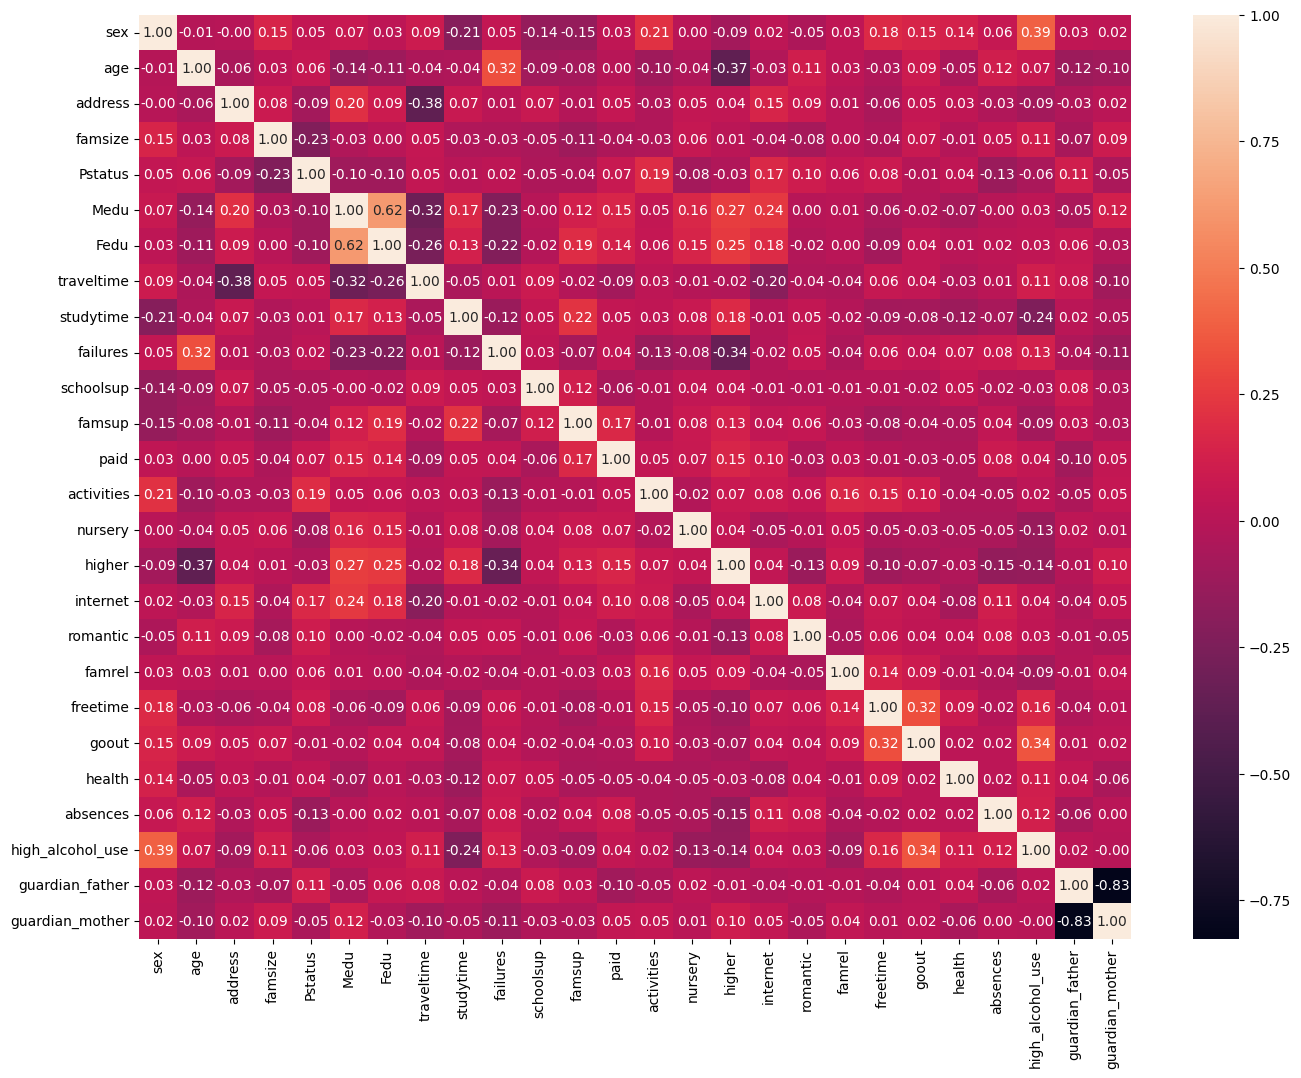

In [1352]:
# it was difficult to see numbers, so we will increase the figure size:
plt.figure(figsize=(16, 12))

# on this correlation matrix we can see the most important supported variables:
# median_income. Also, "ocean_proximity_<1H OCEAN" variale correlate with out target variable and
# "ocean_proximity_INLAND" has negative correlation. 
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')

#### From correlation matrix we can see that "sex","famsize""failures","goout", "higher", "freetime" and "absences" variables have the highest correlation with "high_alcohol_use"

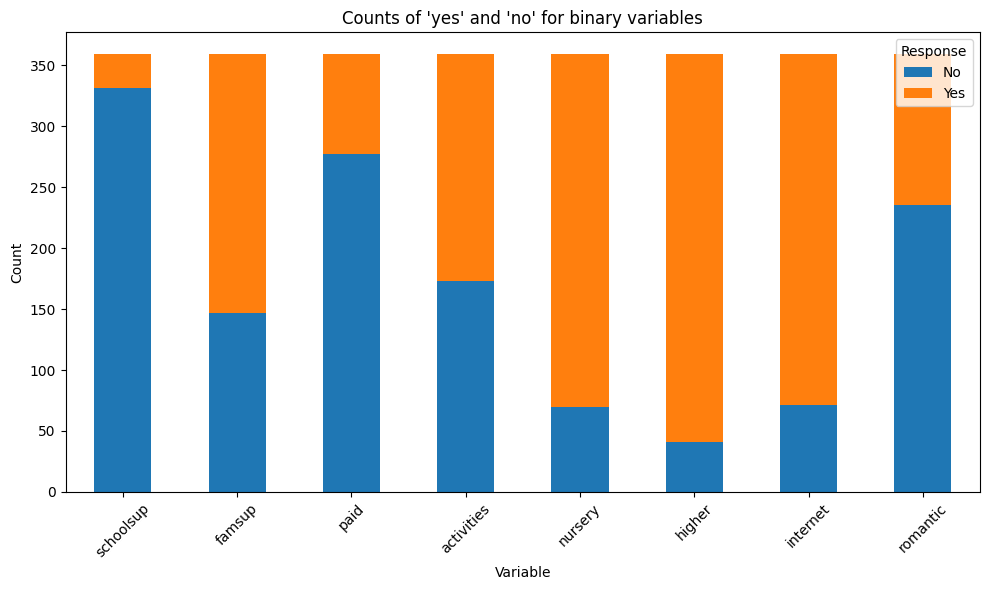

In [1353]:
# List of binary columns
binary_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# Create a DataFrame of value counts
binary_counts = pd.DataFrame({col: df[col].value_counts() for col in binary_cols}).T

# Rename columns to handle missing values if any variable has only one category
binary_counts = binary_counts.rename(columns={True: 'Yes', False: 'No'}).fillna(0)

# Plot
binary_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Counts of 'yes' and 'no' for binary variables")
plt.ylabel("Count")
plt.xlabel("Variable")
plt.xticks(rotation=45)
plt.legend(title='Response')
plt.tight_layout()
plt.show()

#### So, we can see that "higher" and "internet" are almost entirely "Yes", and "schoolsup" and "paid" are almost "No" -> this is imbalanced variables. Only "higher" variable correlates with target variable. I will drop"internet" "schoolsup" and "paid" as they add noise.

In [1354]:
columns_to_drop_2 = ["internet", "schoolsup", "paid"]

df = df.drop(columns_to_drop_2, axis=1)
df.head(5)

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,higher,romantic,famrel,freetime,goout,health,absences,high_alcohol_use,guardian_father,guardian_mother
0,0,18,1,0,1,3,3,1,2,0,...,1,1,5,3,4,5,0,0,1,0
1,1,15,1,0,1,4,0,2,4,0,...,1,0,3,4,3,1,8,0,0,1
2,1,17,1,0,1,4,4,1,2,0,...,1,1,4,5,5,2,14,0,0,1
3,0,16,1,0,1,4,3,1,2,0,...,1,0,4,3,5,2,2,0,0,1
4,1,18,1,1,1,3,4,1,2,0,...,1,1,4,3,3,5,6,0,0,1


###  X/y and train/test split

In [1355]:
# a small trick => use everything else except, the target
X = df.drop("high_alcohol_use", axis=1)

# our target variable is y
y = df['high_alcohol_use']

In [1356]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [1357]:


#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import uniform

# initialize testable parameters
# Since we have to wrap LinearSVC into CalibratedClassifierCV
# we have to use this estimator__ prefix in the parameters
#param_dist = {
#     'n_estimators': [5,],
#     'max_depth': [3,4,5,6,7,8,9,10,11,12],
# }

 # start finding the optimal parameters with RandomizedSearchCV!
 # RandomizedSearchCV is usually way faster than GridSearchCV
 # .... but it's also mostly random
#test_model = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1200, verbose=3, n_jobs=-1, cv=5, random_state=42)
#test_model.fit(X_train, y_train)

In [1358]:
#test_model.best_params_

In [1359]:
#model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=60, max_depth=8))
#model.fit(X_train, y_train)

### Create classifier and train the model

In [1360]:
# classification
model = make_pipeline(StandardScaler(), RandomForestClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

### Classification error metrics

In [1361]:
 # get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [1362]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        63
           1       0.90      0.70      0.79        27

    accuracy                           0.89        90
   macro avg       0.89      0.84      0.86        90
weighted avg       0.89      0.89      0.88        90


Model overall accuracy: 88.89%


[[61  2]
 [ 8 19]]


<Axes: >

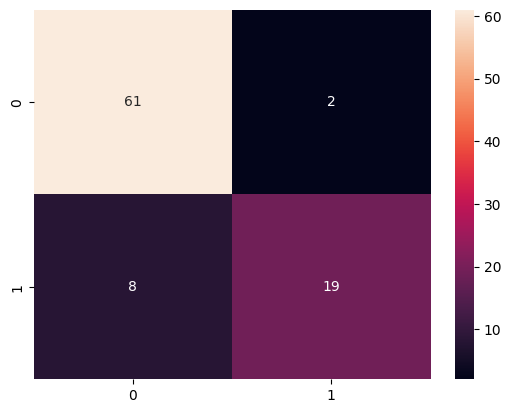

In [1363]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [1364]:
 # The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model
# roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1])
roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1])

0.9479717813051146

###  Using the model in practice

In [1365]:
df.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'famsup', 'activities',
       'nursery', 'higher', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'high_alcohol_use', 'guardian_father',
       'guardian_mother'],
      dtype='object')

In [1366]:
df.head(5)

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,higher,romantic,famrel,freetime,goout,health,absences,high_alcohol_use,guardian_father,guardian_mother
0,0,18,1,0,1,3,3,1,2,0,...,1,1,5,3,4,5,0,0,1,0
1,1,15,1,0,1,4,0,2,4,0,...,1,0,3,4,3,1,8,0,0,1
2,1,17,1,0,1,4,4,1,2,0,...,1,1,4,5,5,2,14,0,0,1
3,0,16,1,0,1,4,3,1,2,0,...,1,0,4,3,5,2,2,0,0,1
4,1,18,1,1,1,3,4,1,2,0,...,1,1,4,3,3,5,6,0,0,1


In [1369]:
df.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,higher,romantic,famrel,freetime,goout,health,absences,high_alcohol_use,guardian_father,guardian_mother
count,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,...,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000
mean,0.532033,16.877437,0.713092,0.331476,0.874652,2.660167,2.389972,1.587744,1.905292,0.311978,...,0.885794,0.345404,3.963788,3.317549,3.359331,3.598886,4.888579,0.303621,0.233983,0.690808
std,0.499669,1.303848,0.452950,0.471401,0.331575,1.126795,1.130338,0.796266,0.836960,0.711161,...,0.318505,0.476163,0.966664,1.056768,1.196651,1.430161,6.648716,0.460463,0.423953,0.462806
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.000000,1.000000,0.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,1.000000
75%,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,5.000000,4.000000,4.000000,5.000000,8.000000,1.000000,0.000000,1.000000
max,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000,1.000000,1.000000


In [1367]:
tester_row = {
    'sex': 0, 
    'age': 17, 
    'address': 0,
    'famsize': 1, 
    'Pstatus': 0,
    'Medu': 4, 
    'Fedu':3,
    'traveltime':4, 
    'studytime':4, 
    'failures':1, 
    'famsup':0, 
    'activities':0,
    'nursery':0, 
    'higher':0, 
    'romantic':1, 
    'famrel':1, 
    'freetime':5, 
    'goout':5,
    'health':1, 
    'absences':80, 
    'guardian_father':1,
    'guardian_mother':0,
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])
# tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Does the student has high alcohol comsumption? (Yes/No):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.38 0.62]]

Does the student has high alcohol comsumption? (Yes/No):
Yes
-------------------


In [1368]:
### Model has improved by finding the optimal parameters, but still it has difficulties to predict 1 class. 
### 13 our of 30 is predicted wrong. Model overall accuracy: 87.50%. The AUC score is 0.87, which is good. Model is not working good propable because of imbalanced dataset.
###  I will try to downsample the majority class again, but this time I will use 250 rows.


### Model works much better with 359 rows, but still 8 wrong predictions out of 27 for class 1.